In [2]:
import h5py
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools
"""
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='', train=True, transform=trans, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
a=iter(train_loader)
print(a.next()[0].shape)
exit(0)
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class CaptionDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, data_name,data_type='None', transform=None):
        """
        :param data_folder: folder where data files are stored
        :param data_name: base name of processed datasets
        :param split: split, one of 'TRAIN', 'VAL', or 'TEST'
        :param transform: image transform pipeline
        """

        # Open hdf5 file where images are stored
        add=''
        if data_type=='VAL':
            add='_VAL' 
        self.h = h5py.File(os.path.join(data_folder, data_name + add + '.h5'), 'r')
        self.imgs = self.h['X_train']
        #print(self.imgs[4232])
        #self.imgs=torch.Tensor(self.imgs)
        #self.imgs=self.imgs.resize((21223,1,256,256))
        self.split = data_type
        # Captions per image
        self.value = self.h['Y_train']
        self.value=np.array(self.value)
        self.value=np.array([np.where(r==1)[0][0] for r in self.value])
        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.value)

    def __getitem__(self, i):
        # Remember, the Nth caption corresponds to the (N // captions_per_image)th image
        img = torch.FloatTensor(self.imgs[i] / 255.)
        value=torch.LongTensor([self.value[i]])
        img=img.unsqueeze(0)
        if self.transform is not None:
            img = self.transform(img)
        #print(img.shape)
        return img,value.squeeze(0)
    def __len__(self):
        return self.dataset_size


data_folder = 'D:\REMBRANDT'
data_name='data'
batch_size=32
workers=0
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])

normalize=transforms.Normalize((0.1307,), (0.3081,))

dataset=CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize]))
train, val = torch.utils.data.random_split(dataset, [20000,1223])

train_loader = torch.utils.data.DataLoader(
        train,
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

val_loader =  torch.utils.data.DataLoader(
        val,
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
#print(iter(val_loader).next()[0].shape)
#exit(0)
#print(iter(train_loader).next())
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.5)
        self.fc1 = nn.Linear(65536, 1024)
        self.fc2 = nn.Linear(1024, 3)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        #print("out",out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = ConvNet()

In [3]:
learning_rate=0.001
num_epochs=10
# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
model=model.to(device)
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images.to(device))
        #print(outputs[0])
        #print(labels[0])
        loss = criterion(outputs.to(device), labels.to(device))
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device)).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

print("Training Done...")

Epoch [1/10], Step [100/625], Loss: 0.7171, Accuracy: 68.75%
Epoch [1/10], Step [200/625], Loss: 0.7272, Accuracy: 71.88%
Epoch [1/10], Step [300/625], Loss: 0.9253, Accuracy: 50.00%
Epoch [1/10], Step [400/625], Loss: 0.5597, Accuracy: 78.12%
Epoch [1/10], Step [500/625], Loss: 0.7054, Accuracy: 65.62%
Epoch [1/10], Step [600/625], Loss: 0.5425, Accuracy: 78.12%
Epoch [2/10], Step [100/625], Loss: 0.6840, Accuracy: 65.62%
Epoch [2/10], Step [200/625], Loss: 0.8232, Accuracy: 65.62%
Epoch [2/10], Step [300/625], Loss: 0.7665, Accuracy: 65.62%
Epoch [2/10], Step [400/625], Loss: 0.6488, Accuracy: 71.88%
Epoch [2/10], Step [500/625], Loss: 0.4778, Accuracy: 84.38%
Epoch [2/10], Step [600/625], Loss: 0.6679, Accuracy: 81.25%
Epoch [3/10], Step [100/625], Loss: 0.5742, Accuracy: 71.88%
Epoch [3/10], Step [200/625], Loss: 0.4404, Accuracy: 81.25%
Epoch [3/10], Step [300/625], Loss: 0.7090, Accuracy: 71.88%
Epoch [3/10], Step [400/625], Loss: 0.4549, Accuracy: 81.25%
Epoch [3/10], Step [500/

Validation Accuracy: 
 Loss: 0.3626, Accuracy: 84.38%
 Loss: 0.5269, Accuracy: 84.38%
 Loss: 0.3915, Accuracy: 87.50%
torch.Size([1223])
tensor([[162,  48,  14],
        [ 61, 720,  39],
        [ 18,  41, 120]])
Confusion matrix, without normalization
tensor([[162,  48,  14],
        [ 61, 720,  39],
        [ 18,  41, 120]])


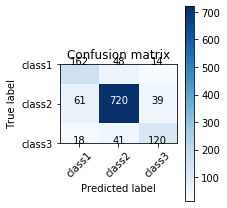

torch.Size([1, 1, 256, 256])
tensor([[0.7255, 0.1616, 0.1128]], grad_fn=<SoftmaxBackward>)
tensor([0])


In [4]:
print("Validation Accuracy: ")
# test=iter(val_loader).next()[0][0].unsqueeze(0)
# print(test.shape)
# output=model(test.to(device))
# print(torch.softmax(output,dim=1).argmax(dim=1))
# exit(0)
total_pred=torch.LongTensor([])
total_label=torch.LongTensor([])
for i, (images,labels) in enumerate(val_loader):
    outputs=model(images.to(device))
    #print(torch.softmax(outputs,dim=1).argmax(dim=1))
    #print(labels)
    loss=criterion(outputs.to(device),labels.to(device))
    outputs=torch.softmax(outputs,dim=1).argmax(dim=1)
    total = labels.size(0)
    total_pred=torch.cat((total_pred.to(device),outputs),0)
    total_label=torch.cat((total_label.to(device),labels.to(device)),0)
    #_, predicted = torch.max(outputs.data, 1)
    predicted=outputs
    correct = (predicted == labels.to(device)).sum().item()
    acc_list.append(correct / total)  
    if (i+1)%10 == 0: 
        print(' Loss: {:.4f}, Accuracy: {:.2f}%'
                    .format(loss.item(),
                            (correct / total) * 100))
print(total_pred.shape)
stacked = torch.stack(
    (
        total_label
        ,total_pred
    )
    ,dim=1
)
cmt = torch.zeros(3,3, dtype=torch.int64)
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
print(cmt)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure(figsize=(3,3))
names=('class1','class2','class3')
plot_confusion_matrix(cmt, names)
plt.show()

##### Testing using individual images #######
##### If you are reading an image externally ###
##### make sure you convert it to tensor of dimension: ###
#####  [1,1,256,256]. ###

test=iter(val_loader).next()[0][0].unsqueeze(0)
print(test.shape)
output=model(test.to(device))
print(torch.softmax(output,dim=1))
print(torch.softmax(output,dim=1).argmax(dim=1))